<a href="https://colab.research.google.com/github/carlosrodrigues07/hate-speech-multimodal-analysis/blob/master/Discurso_de_%C3%B3dio_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [203]:
# Manipulação de dados e sistema

import os
import re
import warnings

import numpy as np
import pandas as pd

# Suprimir warnings (opcional)
warnings.filterwarnings('ignore')


# Visualização

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


# NLP - Natural Language Processing

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [204]:
import kagglehub

path = kagglehub.dataset_download("aditya1220/hate-speech-detection-dataset")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'hate-speech-detection-dataset' dataset.
Path to dataset files: /kaggle/input/hate-speech-detection-dataset


In [205]:
# Verificar quais arquivos existem dentro da pasta baixada
print(os.listdir(path))

# Montar o caminho para o arquivo de treino
csv_path = os.path.join(path, "Dataset/Split Dataset/Training_meme_dataset.csv")

# Carregar com pandas
df = pd.read_csv(csv_path)

df


['Dataset']


,image_name,sentence,label
0,LJ3r8Gy.jpg.png,OFFICIAL BERNIE SANDERS DRINKING GAME ! Every ...,Non-offensiv
1,qDnIIHA.png,2:28 PM THIS IS A WALL INSIDE A NAZI GAS CHAMB...,offensive
2,1JQk5NF.png,o shit waddup ! BERNIE SANDERS COM,offensive
3,iMMNq.png,`` MITT ROMNEY IS THE WORST REPUBLICAN IN THE ...,Non-offensiv
4,jAi3iI1.png,Anonymous ( ID : duqdA1io a 08/05/16 ( Fri ) 1...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,`` I HOPE '' THE TRUMP FOUNDATION HAS N'T BROK...,Non-offensiv
441,ZEjNdo0.png,31 6:26 PM geez . 5 minutes ago I know Bernie ...,Non-offensiv
442,34nLFqO.png,"*me , voting for Bernie Sanders Feel the Bern !",Non-offensiv
443,gzWfYg3.png,YOU SAIOTHATAVOTEFORGARY JOHNSONWASAVOTEFOR HI...,offensive


In [206]:
df.shape

(445, 3)

In [207]:
df.columns

Index(['image_name', 'sentence', 'label'], dtype='object')

In [208]:
df.duplicated().sum()

np.int64(0)

In [209]:
df.isnull().sum()

,0
image_name,0
sentence,0
label,0


In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  445 non-null    object
 1   sentence    445 non-null    object
 2   label       445 non-null    object
dtypes: object(3)
memory usage: 10.6+ KB


In [211]:
df.nunique()

,0
image_name,445
sentence,445
label,2


In [212]:
df['label'].unique()

array(['Non-offensiv', 'offensive'], dtype=object)

In [213]:
df['label'].value_counts()

,count
label,
Non-offensiv,258
offensive,187


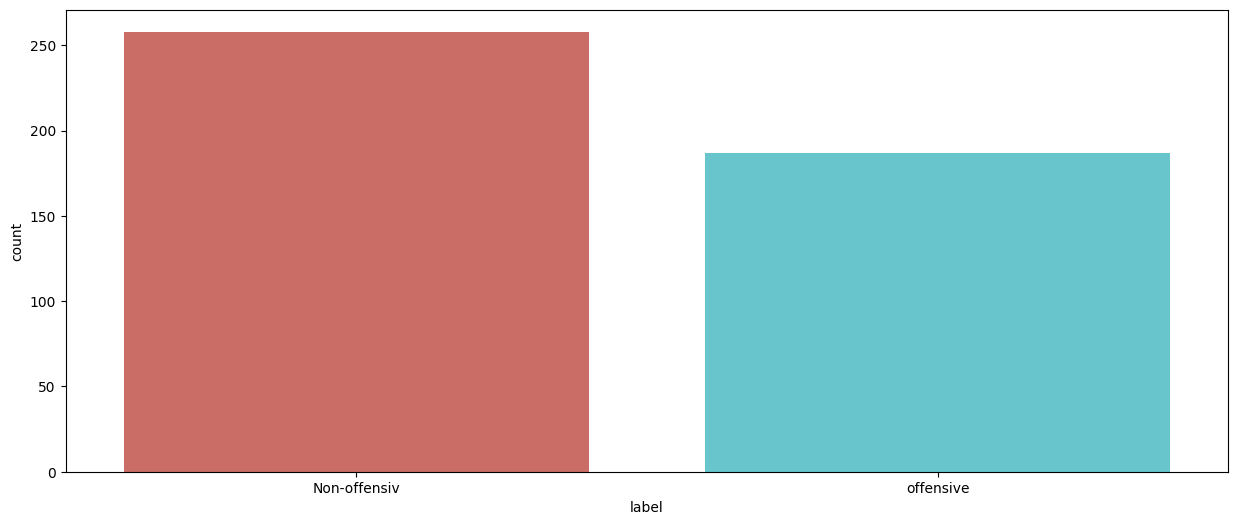

In [214]:
plt.figure(figsize=(15,6))
sns.countplot(x = 'label', data = df, palette = 'hls')
plt.show()

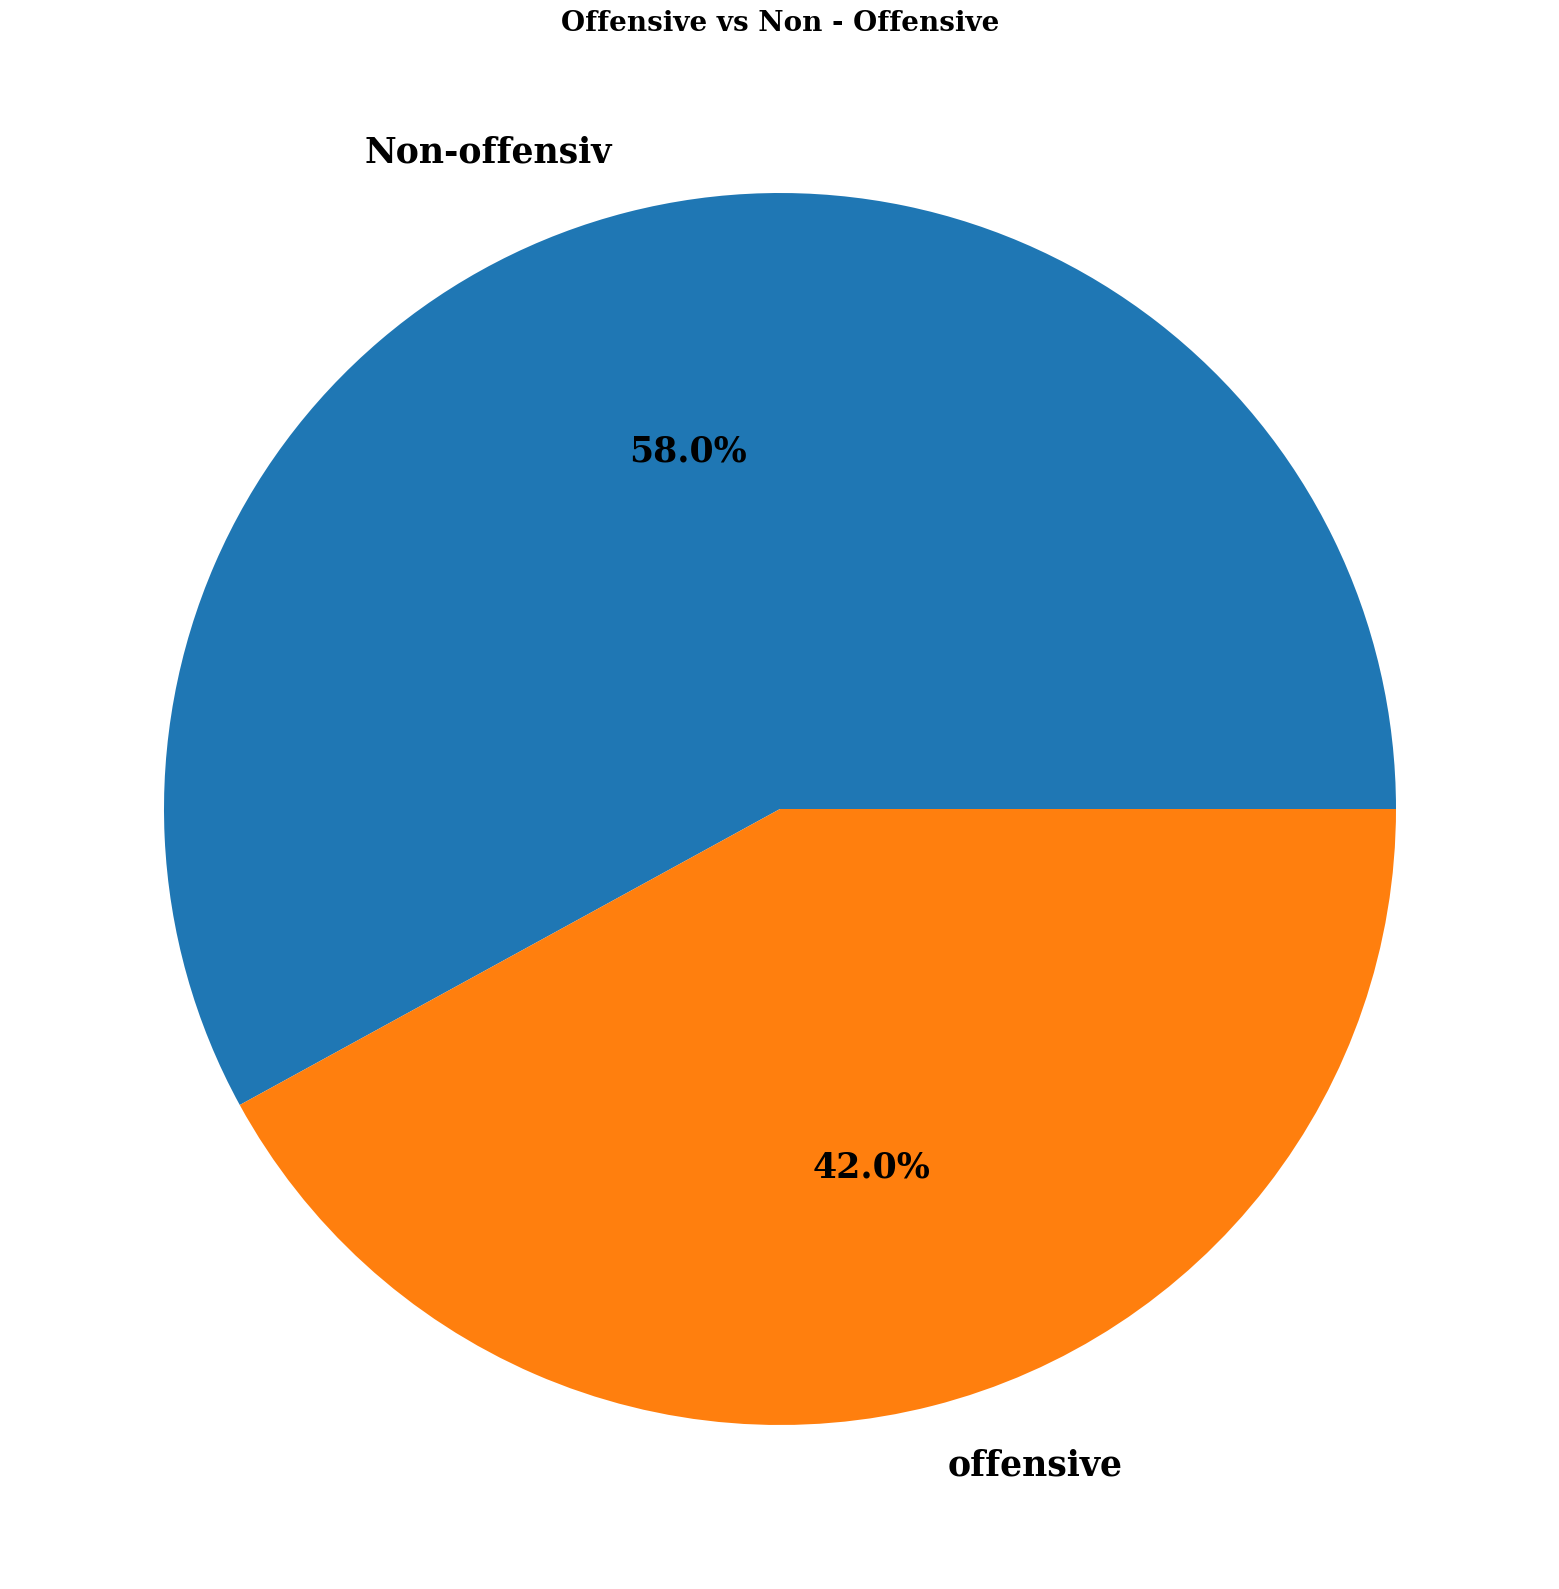

In [215]:
plt.figure(figsize=(30,20))
plt.pie(df['label'].value_counts(), labels=df['label'].value_counts().index,
        autopct='%1.1f%%', textprops={ 'fontsize': 25,
                                       'color': 'black',
                                        'weight': 'bold',
                                        'family': 'serif' })
hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Offensive vs Non - Offensive', size=20, **hfont)
plt.show()

In [216]:
df_new = df.copy()

In [217]:
def clean_text(text):
    text = text.lower()
    text = text.strip()
    return text


In [218]:
df_new['sentence'] = df_new['sentence'].astype(str).apply(clean_text)


In [219]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [220]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [221]:
df_new['sentence']= df_new['sentence'].apply(lambda x:remove_punctuation(x))

In [222]:
def tokenization(text):
    # Use uma expressão regular para dividir o texto em tokens
    tokens = re.split(r'\W+', text)
    return tokens

In [223]:
df_new['sentence']= df_new['sentence'].apply(lambda x: tokenization(x))

In [224]:
df_new['sentence']

,sentence
0,"[official, bernie, sanders, drinking, game, ev..."
1,"[228, pm, this, is, a, wall, inside, a, nazi, ..."
2,"[o, shit, waddup, bernie, sanders, com]"
3,"[, mitt, romney, is, the, worst, republican, i..."
4,"[anonymous, id, duqda1io, a, 080516, fri, 1632..."
...,...
440,"[, i, hope, the, trump, foundation, has, nt, b..."
441,"[31, 626, pm, geez, 5, minutes, ago, i, know, ..."
442,"[me, voting, for, bernie, sanders, feel, the, ..."
443,"[you, saiothatavoteforgary, johnsonwasavotefor..."


In [225]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## VADER (Valence Aware Dictionary and sEntiment Reasoner)

O **VADER** é uma ferramenta de análise de sentimentos baseada em regras, projetada especificamente para analisar o sentimento em textos, especialmente em conteúdos de redes sociais como tweets.  
Ele é pré-treinado com um léxico de sentimentos que contém palavras anotadas com sua polaridade (positiva, negativa ou neutra) e com pontuações de intensidade.

O VADER consegue lidar tanto com a **polaridade do sentimento** quanto com a **intensidade**, fornecendo não apenas se um texto é positivo, negativo ou neutro, mas também o quão intenso é esse sentimento.  
É muito útil para analisar rapidamente textos curtos e informais, sem a necessidade de dados de treinamento ou modelos complexos.

---

## Corpus de Stopwords

**Stopwords** são palavras comuns que geralmente são removidas do texto durante tarefas de processamento de linguagem natural (PLN), pois normalmente não carregam um significado relevante para a tarefa em questão.

O **NLTK** fornece um corpus de stopwords que contém listas dessas palavras em vários idiomas, como inglês, francês, alemão, entre outros.  
Essas stopwords incluem palavras frequentes como *"the"*, *"and"*, *"is"*, *"in"*, etc., que aparecem com muita frequência nos textos, mas não contribuem significativamente para sua compreensão ou análise.

A remoção de stopwords pode ajudar a melhorar o desempenho e a eficiência de tarefas de PLN, como **classificação de texto**, **modelagem de tópicos** e **recuperação de informação**, ao reduzir ruídos e focar em palavras mais relevantes.

---

O **VADER** é uma ferramenta voltada para **análise de sentimentos**, enquanto o **Corpus de Stopwords** fornece listas de palavras comuns que geralmente são removidas durante o pré-processamento de texto. Ambos são recursos úteis para tarefas de processamento de linguagem natural em Python.


In [226]:
stopwords = nltk.corpus.stopwords.words('english')


In [227]:
def remove_stopwords(text):
    output= " ".join(i for i in text if i not in stopwords)
    return output

In [228]:
df_new['sentence']= df_new['sentence'].apply(lambda x:remove_stopwords(x))

In [229]:
df_new['sentence']

,sentence
0,official bernie sanders drinking game every ti...
1,228 pm wall inside nazi gas chamber dwebs demo...
2,shit waddup bernie sanders com
3,mitt romney worst republican country putup ba...
4,anonymous id duqda1io 080516 fri 163248 842315...
...,...
440,hope trump foundation nt broken laws personal...
441,31 626 pm geez 5 minutes ago know bernie fathe...
442,voting bernie sanders feel bern
443,saiothatavoteforgary johnsonwasavotefor hillar...


## WordNet

O **WordNet** é um banco de dados lexical da língua inglesa que fornece relações semânticas entre palavras, como **sinônimos**, **antônimos**, **hiperônimos**, **hipônimos**, entre outras.  
Ele é um recurso valioso para diversas tarefas de **processamento de linguagem natural (PLN)**, incluindo **desambiguação de sentido de palavras**, **medição de similaridade semântica** e **recuperação de informação**.

---

## Casos de Uso Comuns do WordNet

### 🔹 Encontrar Sinônimos e Antônimos
O WordNet fornece conjuntos de sinônimos (*synsets*) para palavras, permitindo encontrar palavras alternativas com significados semelhantes ou opostos.

### 🔹 Explorar Hierarquias de Palavras
O WordNet organiza palavras em hierarquias com base em suas relações semânticas, como:
- **Hiperônimos**: termos mais gerais  
- **Hipônimos**: termos mais específicos

### 🔹 Desambiguação de Sentido de Palavras
O WordNet ajuda a identificar o significado correto de palavras que possuem múltiplos sentidos, fornecendo definições e relações semânticas.

### 🔹 Análise de Texto e Recuperação de Informação
O WordNet pode ser utilizado para aprimorar tarefas de análise de texto, como **classificação de documentos**, **agrupamento (clustering)** e **recuperação de informação**, incorporando conhecimento semântico.

---

Para explorar melhor o WordNet, você pode utilizar as funções fornecidas pelo **NLTK**, que permitem acessar recursos como sinônimos, antônimos, hiperônimos, hipônimos e muito mais.  
S


In [230]:
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [231]:
porter_stemmer = PorterStemmer()

def stemmer(sentence):
    words = word_tokenize(sentence)
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    stemmed_sentence = ' '.join(stemmed_words)
    return stemmed_sentence

df_new['sentence'] = df_new['sentence'].apply(lambda x: stemmer(x))

In [232]:
def clean_text(text):
    text = re.sub('\[.*\]','', text).strip()
    text = re.sub('\S*\d\S*\s*','', text).strip()
    return text.strip()

In [233]:
df_new['sentence']

,sentence
0,offici berni sander drink game everi time bern...
1,228 pm wall insid nazi ga chamber dweb democra...
2,shit waddup berni sander com
3,mitt romney worst republican countri putup bar...
4,anonym id duqda1io 080516 fri 163248 84231555 ...
...,...
440,hope trump foundat nt broken law person sign c...
441,31 626 pm geez 5 minut ago know berni father f...
442,vote berni sander feel bern
443,saiothatavoteforgari johnsonwasavotefor hillar...


Essa função `clean_text` parece ter sido projetada para realizar algumas operações básicas de limpeza de texto utilizando **expressões regulares**. Vamos analisar o que cada linha faz:

- **`text = re.sub('\[.*\]','', text).strip()`**  
  Esta linha utiliza uma expressão regular para remover qualquer texto que esteja entre colchetes `[...]`.

  - `\[.*\]` corresponde a qualquer sequência de caracteres entre colchetes.
  - `re.sub()` é usado para substituir o padrão encontrado por uma string vazia, removendo esse trecho do texto.
  - `.strip()` remove espaços em branco no início e no final da string.

- **`text = re.sub('\S*\d\S*\s*','', text).strip()`**  
  Esta linha utiliza uma expressão regular para remover sequências de caracteres que contenham **dígitos**.

  - `\S*\d\S*` corresponde a qualquer sequência de caracteres não brancos que contenha pelo menos um dígito (`\d`).
  - `\S*` captura caracteres não brancos antes e depois do dígito.
  - `\s*` captura possíveis espaços em branco após a sequência.
  - `re.sub()` substitui essas sequências por uma string vazia.
  - `.strip()` é aplicado novamente para remover espaços residuais no início e no final do texto.

- **`return text.strip()`**  
  Garante que qualquer espaço em branco restante nas extremidades do texto seja removido antes de retornar o resultado final.

**Em resumo**, essa função tem como objetivo remover padrões específicos do texto de entrada, como conteúdos entre colchetes e sequências que contenham números, retornando um texto limpo e sem espaços desnecessários nas extremidades.


In [234]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: clean_text(x))

In [235]:
def remove_urls(vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

A função `remove_urls` foi projetada para remover URLs do texto de entrada usando uma expressão regular. Vamos analisar o que cada parte da expressão regular faz:

r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b':

(https|http)?: Esta parte corresponde a "https" ou "http", com o "?" indicando que o "s" é opcional.

:\/\/: Isso corresponde aos dois pontos e duas barras que fazem parte da sintaxe da URL.

(\w|\.|\/|\?|\=|\&|\%)*: Esta parte corresponde a qualquer sequência de caracteres que possa ocorrer em uma URL, incluindo caracteres alfanuméricos (\w), pontos (\.), barras (\/), pontos de interrogação (\?), sinais de igual (\=), e comerciais (\&) e sinais de porcentagem (\%). O quantificador * permite zero ou mais ocorrências desses caracteres.
\b: Este é um delimitador de palavra, garantindo que a URL seja correspondida como uma palavra inteira.

re.sub(): Esta função é usada para substituir as URLs correspondentes por uma string vazia, removendo-as efetivamente do texto de entrada.

flags=re.MULTILINE: Esta opção permite que os marcadores "^" e "$" correspondam no início e no final de cada linha do texto de entrada, respectivamente.

return(vTEXT): O texto limpo, com as URLs removidas, é então retornado.

Em resumo, esta função remove URLs do texto de entrada de forma eficaz, usando correspondência de padrões de expressões regulares e substituição.

In [236]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_urls(x))

In [237]:
def remove_digits(text):
    clean_text = re.sub(r"\b[0-9]+\b\s*", "", text)
    return(text)

## Função `remove_digits`

A função `remove_digits` tem como objetivo remover dígitos do texto de entrada utilizando uma expressão regular. Vamos detalhar o que cada parte da função faz:

### `re.sub(r"\b[0-9]+\b\s", "", text)`
Esta linha utiliza a função `re.sub()` para substituir quaisquer sequências de dígitos por uma string vazia.

- **`\b`**: Representa um limite de palavra (*word boundary*), garantindo que a expressão regular corresponda a palavras inteiras compostas apenas por dígitos.
- **`[0-9]+`**: Corresponde a um ou mais dígitos (de 0 a 9).
- **`\s`**: Corresponde a um ou mais caracteres de espaço em branco (espaços, tabulações etc.) após os dígitos.
- **`""`**: É a string de substituição (vazia), o que efetivamente remove as sequências de dígitos e os espaços associados.

### `return(text)`
Esta linha retorna o texto original **sem modificações**.  
No entanto, isso é um erro lógico: o correto seria retornar a variável `clean_text`, que contém o texto já processado, com os dígitos removidos.


In [238]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_digits(x))

In [239]:
def remove_emojis(data):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    return re.sub(emoji_pattern, '', data)

In [240]:
df_new['sentence'] = df_new['sentence'].apply(lambda x: remove_emojis(x))

In [241]:
df_new['sentence'] = df_new['sentence'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

re.sub(r'\s+[a-zA-Z]\s+', '', x): Esta parte usa a função re.sub() do módulo re para realizar uma substituição de expressão regular em cada frase. \s+: Corresponde a um ou mais caracteres de espaço em branco. [a-zA-Z]: Corresponde a qualquer caractere alfabético único (minúsculo ou maiúsculo). \s+: Corresponde novamente a um ou mais caracteres de espaço em branco. '': Esta é a string de substituição, que é uma string vazia. Ela remove efetivamente qualquer caractere alfabético único cercado por espaços em branco. x: Representa cada frase individual passada para a função lambda.

In [242]:
df_new['sentence'] = df_new['sentence'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [243]:
df_new

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,offici berni sander drink game everi time bern...,Non-offensiv
1,qDnIIHA.png,pm wall insid nazi ga chamber dweb democrat me...,offensive
2,1JQk5NF.png,shit waddup berni sander com,offensive
3,iMMNq.png,mitt romney worst republican countri putup bar...,Non-offensiv
4,jAi3iI1.png,anonym id fri file imag jpg kb repeat digit pa...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,hope trump foundat nt broken law person sign c...,Non-offensiv
441,ZEjNdo0.png,pm geez minut ago know berni father famili kil...,Non-offensiv
442,34nLFqO.png,vote berni sander feel bern,Non-offensiv
443,gzWfYg3.png,saiothatavoteforgari johnsonwasavotefor hillar...,offensive


In [244]:
def remove_punctuation(text):
    punctuation_pattern = r'[^\w\s]'
    return re.sub(punctuation_pattern, '', text)

df_new['sentence'] = df_new['sentence'].apply(remove_punctuation)

A função `remove_punctuation` foi projetada para remover a pontuação do texto de entrada usando uma expressão regular. Vamos analisar o que cada parte da função faz:

1. `punctuation_pattern = r'[^\w\s]'`: Esta linha define um padrão de expressão regular para corresponder a qualquer caractere que não seja um caractere alfanumérico (`\w`, que inclui letras, dígitos e sublinhados) ou um caractere de espaço em branco (`\s`).

- `[^ ... ]` é um conjunto de caracteres negados, correspondendo a qualquer caractere não listado dentro dos colchetes.

- `\w` corresponde a qualquer caractere alfanumérico (letras, dígitos e sublinhados).

- `\s` corresponde a qualquer caractere de espaço em branco (espaço, tabulação, nova linha, etc.).

2. `re.sub(punctuation_pattern, '', text)`: Esta linha usa a função `re.sub()` para substituir quaisquer caracteres que correspondam ao padrão de pontuação por uma string vazia, removendo-os efetivamente do texto de entrada.

- `''` é a string de substituição, que está vazia. Ela remove efetivamente os caracteres de pontuação correspondentes.

3. `` `df_new['sentence'].apply(remove_punctuation):` Esta linha aplica a função `remove_punctuation` a cada elemento na coluna 'sentence' do DataFrame `df_new` usando o método `apply()`.

Em resumo, esta função remove a pontuação do texto de entrada, substituindo os caracteres de pontuação por uma string vazia. Após aplicar esta função a cada frase na coluna 'sentence', o DataFrame `df_new` conterá frases sem nenhum caractere de pontuação.

In [245]:
df_new

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,offici berni sander drink game everi time bern...,Non-offensiv
1,qDnIIHA.png,pm wall insid nazi ga chamber dweb democrat me...,offensive
2,1JQk5NF.png,shit waddup berni sander com,offensive
3,iMMNq.png,mitt romney worst republican countri putup bar...,Non-offensiv
4,jAi3iI1.png,anonym id fri file imag jpg kb repeat digit pa...,Non-offensiv
...,...,...,...
440,a1F6RKt.png,hope trump foundat nt broken law person sign c...,Non-offensiv
441,ZEjNdo0.png,pm geez minut ago know berni father famili kil...,Non-offensiv
442,34nLFqO.png,vote berni sander feel bern,Non-offensiv
443,gzWfYg3.png,saiothatavoteforgari johnsonwasavotefor hillar...,offensive


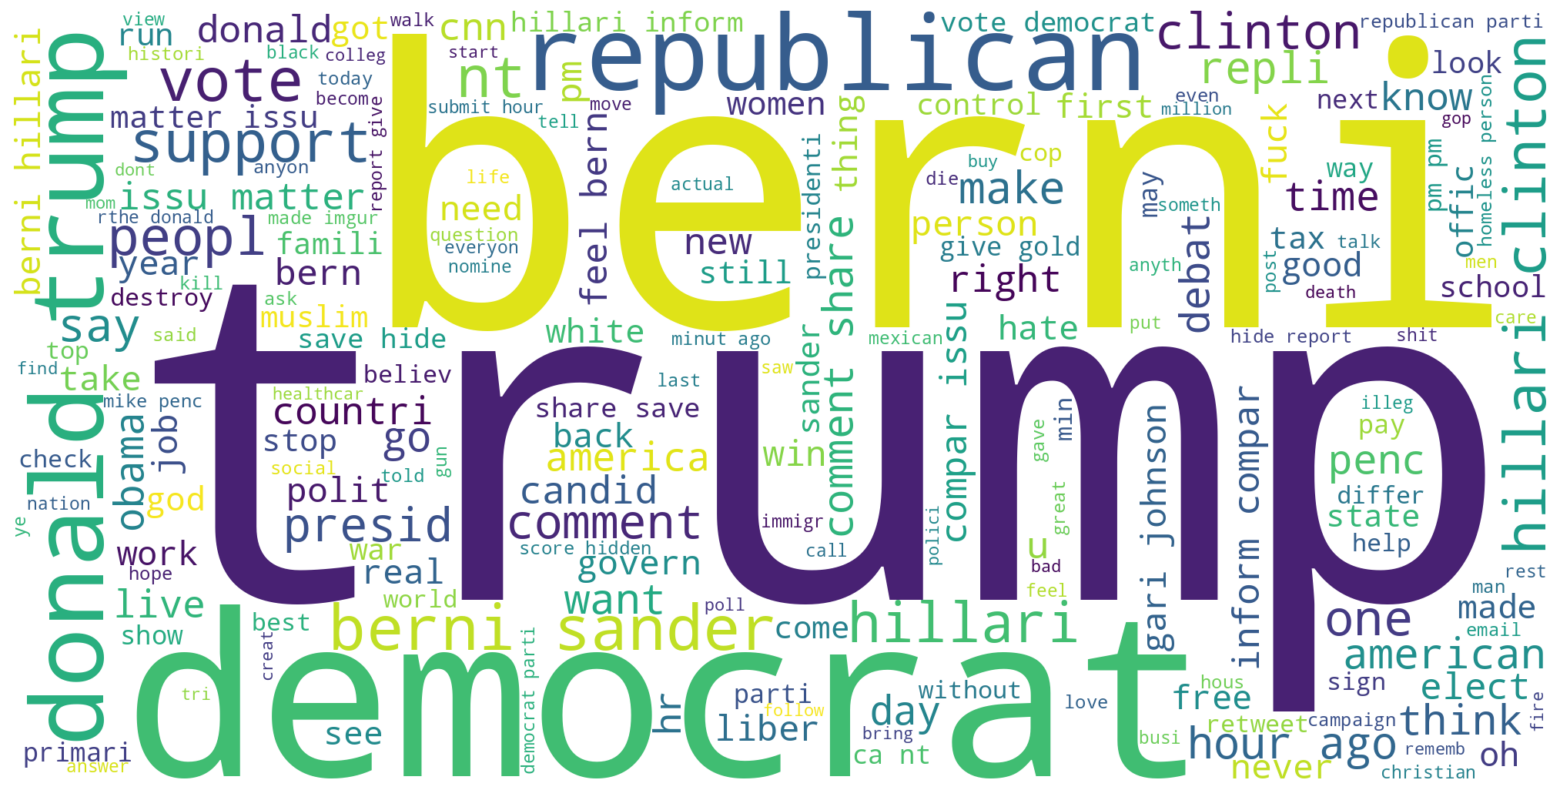

In [246]:
text_data = ' '.join(df_new['sentence'])

wordcloud = WordCloud(
    background_color='white',
    width=2000,
    height=1000
).generate(text_data)

# Converte via PIL (sem usar to_array)
wc_image = np.array(wordcloud.to_image())

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(wc_image, interpolation='bilinear')
ax.axis('off')
plt.show()


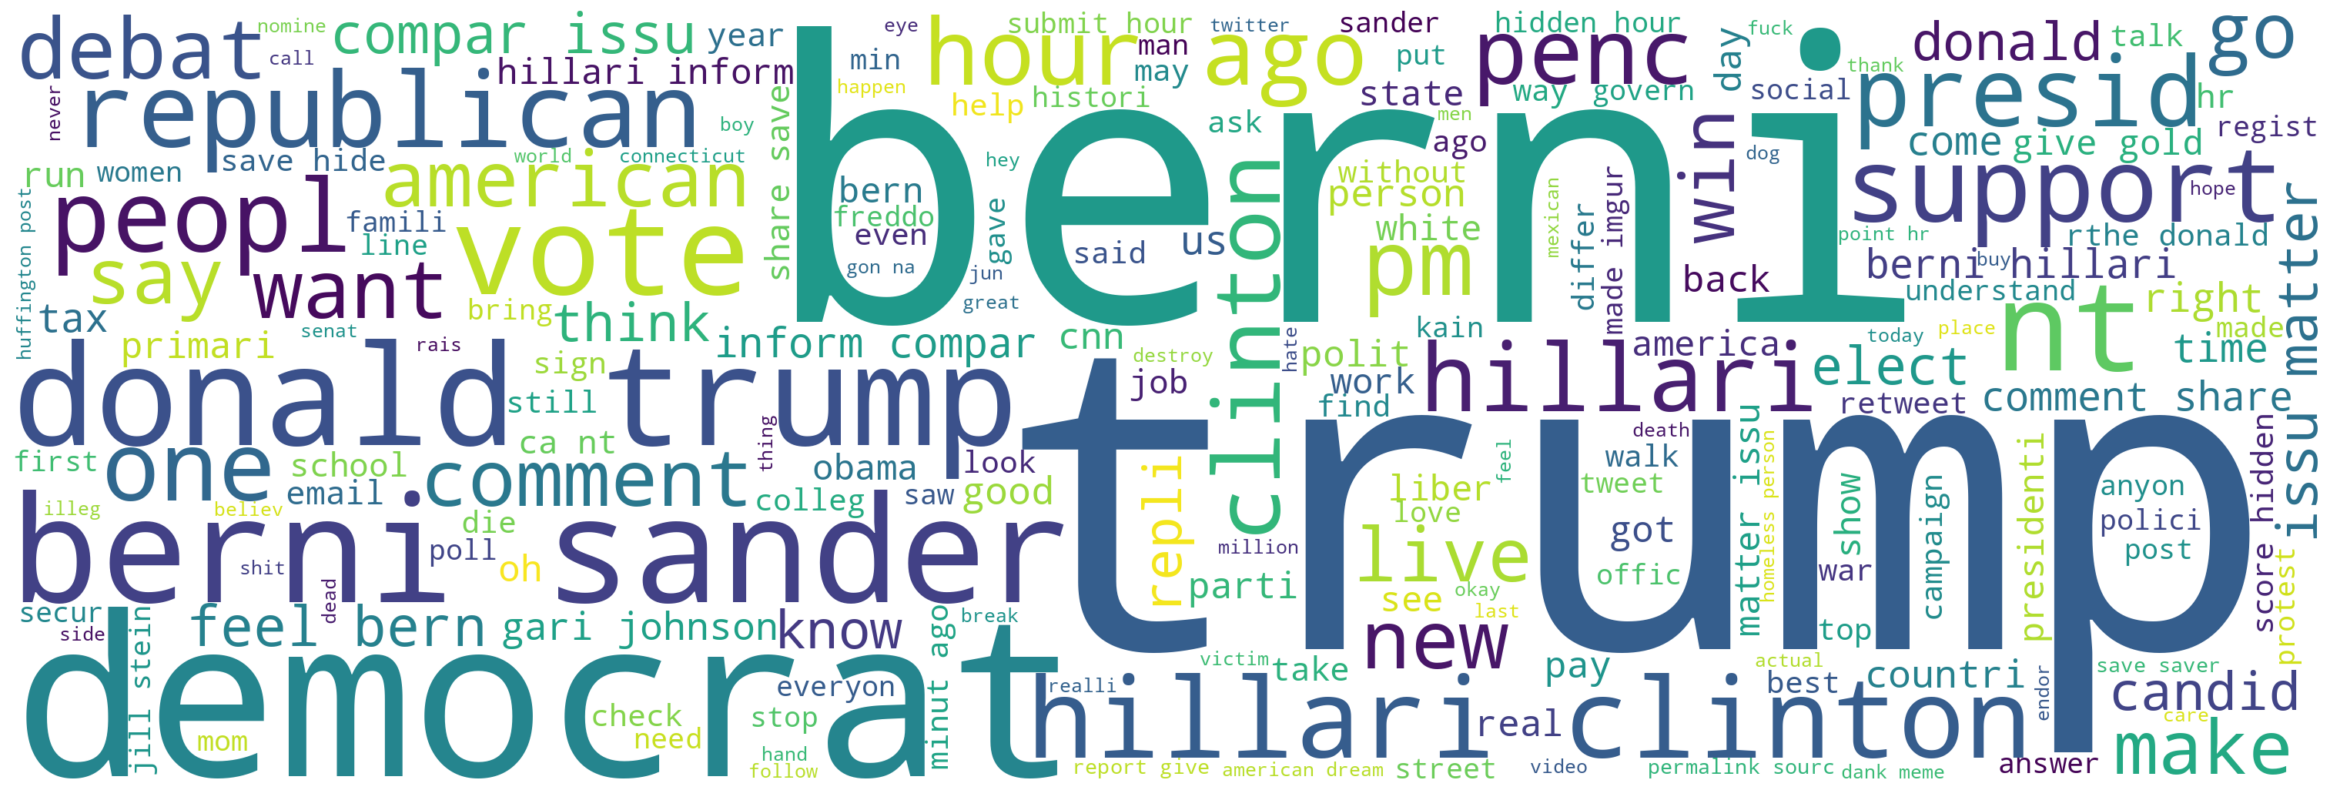

In [247]:
nonoffensive_text_data = ' '.join(
    df_new[df_new['label'] == 'Non-offensiv']['sentence']
)

if nonoffensive_text_data:
    wordcloud = WordCloud(
        background_color='white',
        width=3000,
        height=1000
    ).generate(nonoffensive_text_data)

    fig, ax = plt.subplots(figsize=(30, 10))

    # 🔥 CONVERSÃO CORRETA (PIL → NumPy)
    ax.imshow(np.array(wordcloud.to_image()), interpolation='bilinear')

    ax.axis('off')
    plt.savefig(
        'nonoffensive_text_data_wordcloud1.png',
        bbox_inches='tight',
        pad_inches=0
    )
    plt.show()
else:
    print('No nonoffensive text data to generate a word cloud.')


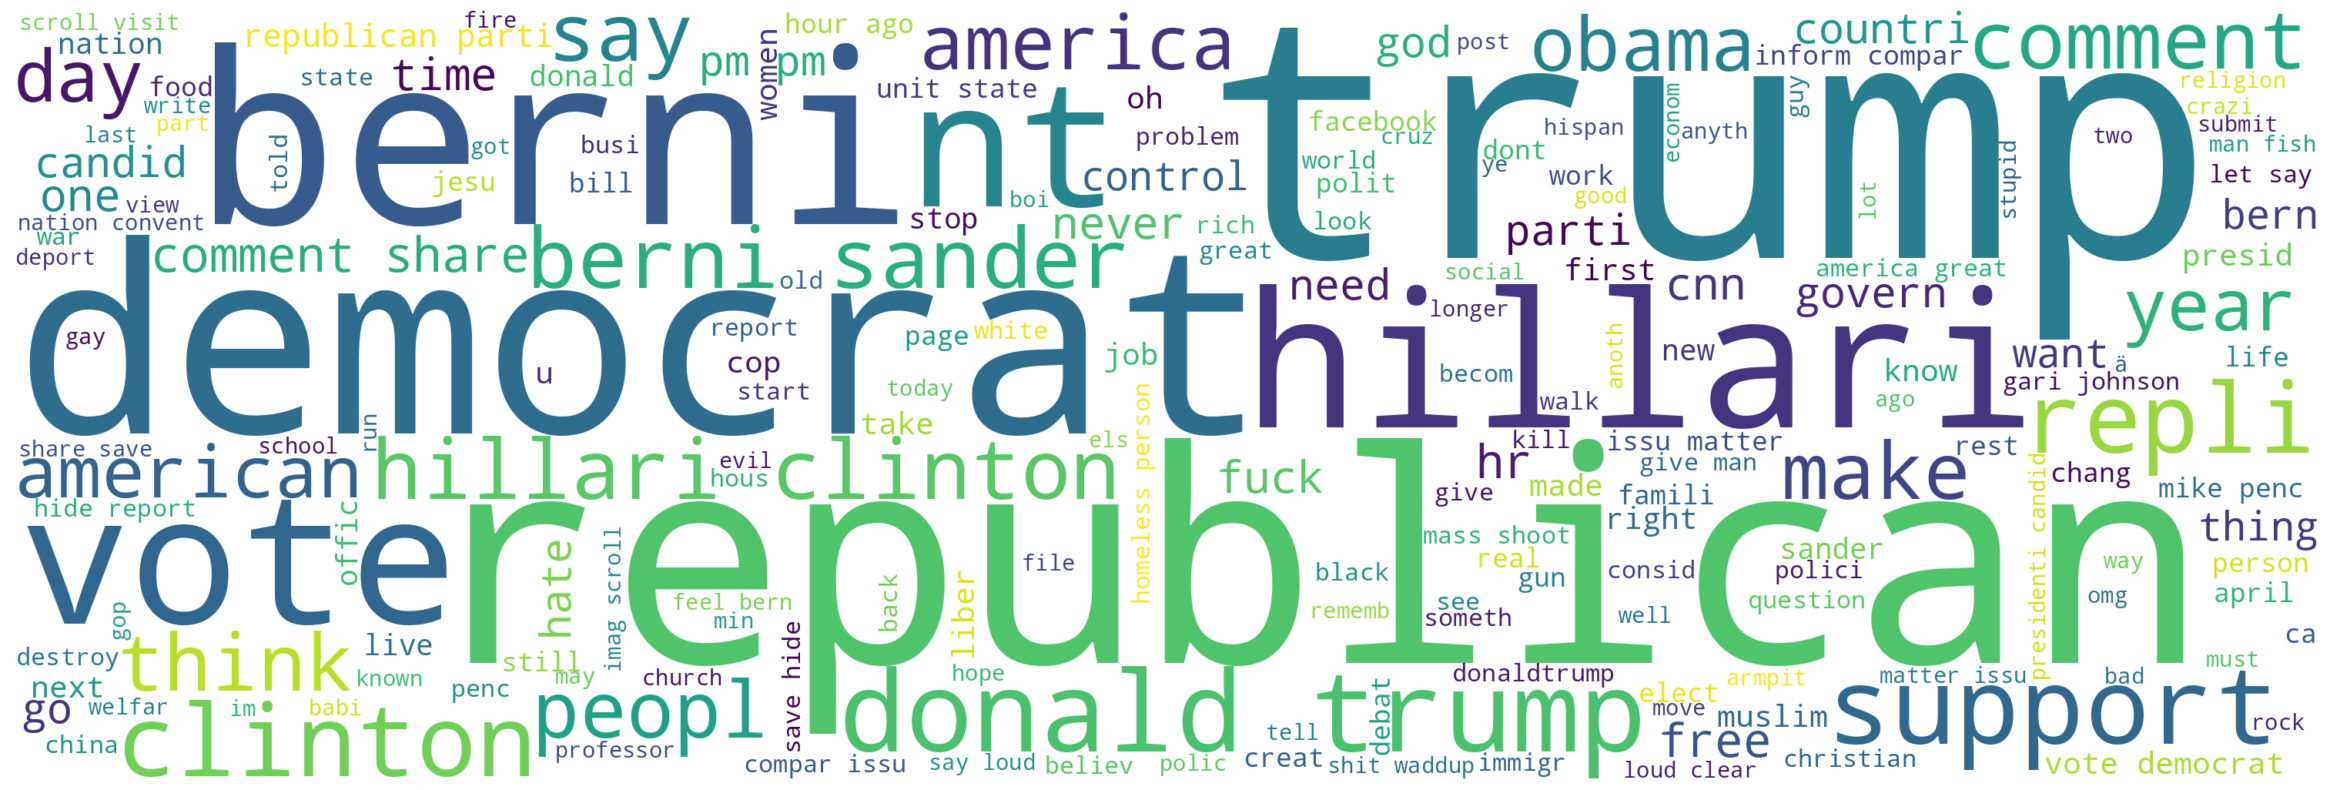

In [248]:
offensive_text_data = ' '.join(
    df_new[df_new['label'] == 'offensive']['sentence']
)

if offensive_text_data:
    wordcloud = WordCloud(
        background_color='white',
        width=3000,
        height=1000
    ).generate(offensive_text_data)

    fig, ax = plt.subplots(figsize=(30, 10))

    #  Conversão correta (PIL → NumPy)
    ax.imshow(np.array(wordcloud.to_image()), interpolation='bilinear')

    ax.axis('off')
    plt.savefig(
        'offensive_text_data_wordcloud1.png',
        bbox_inches='tight',
        pad_inches=0
    )
    plt.show()
else:
    print('No offensive text data to generate a word cloud.')


In [249]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Dense

Shape of preprocessed images array: (445, 224, 224, 3)


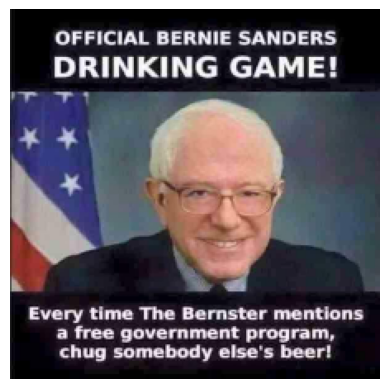

In [250]:
# Imports

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Função de carregamento e pré-processamento

def load_and_preprocess_images(image_folder, image_names, target_size):
    images = []

    for image_name in image_names:
        image_name = str(image_name)  # garante string
        image_path = os.path.join(image_folder, image_name)

        # Corrige automaticamente a extensão .jpg.png
        if not os.path.exists(image_path):
            image_path = image_path + ".png"

        image = cv2.imread(image_path)

        # Se não conseguir carregar, ignora
        if image is None:
            continue

        image = cv2.resize(image, target_size)
        image = image.astype("float32") / 255.0
        images.append(image)

    return np.array(images)


# Preparação dos nomes das imagens

# Garante lista e evita NaN
df_new['image_name'] = df_new['image_name'].astype(str)
image_names = df_new['image_name'].tolist()


# Caminho do dataset (Kaggle)

# Corrected image_folder_path to use the `path` variable from kagglehub download
image_folder_path = os.path.join(path, "Dataset", "Labelled Images")


# Dimensão das imagens

image_width = 224
image_height = 224


# Carregamento das imagens

images = load_and_preprocess_images(
    image_folder=image_folder_path,
    image_names=image_names,
    target_size=(image_width, image_height)
)


# Verificações finais

print("Shape of preprocessed images array:", images.shape)

assert images.shape[0] > 0, " Nenhuma imagem foi carregada!"


# Visualização de teste

plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1. from tensorflow.keras.preprocessing.sequence import pad_sequences:

- pad_sequences é uma função fornecida pelo TensorFlow Keras para pré-processar sequências de dados, como sequências de palavras em tarefas de processamento de linguagem natural ou sequências de dados de séries temporais.
- Ela preenche as sequências até um comprimento especificado adicionando zeros ou trunca as sequências para um comprimento máximo, garantindo uniformidade nos tamanhos de entrada, o que é necessário para alimentar dados em redes neurais.

2. from tensorflow.keras.models import Model:

- Model é uma classe fornecida pelo TensorFlow Keras para definir modelos de redes neurais.
- Ela permite criar modelos com múltiplas entradas e saídas, possibilitando arquiteturas complexas, como redes com múltiplas entradas e múltiplas saídas.

- Você pode definir modelos especificando a(s) entrada(s), a(s) saída(s) e as conexões entre as camadas.
3. from tensorflow.keras.layers import Input, Embedding, LSTM, Conv2D, MaxPooling2D, Flatten, concatenate, Dense:

- Input: Esta classe representa a camada de entrada de um modelo de rede neural no TensorFlow Keras. Ela especifica o formato e o tipo de dados (dtype) dos dados de entrada.

- Embedding: Esta camada é usada para aprender embeddings a partir dos dados de entrada, tipicamente usada em tarefas de processamento de linguagem natural para converter sequências de entrada codificadas em inteiros em vetores densos.

- LSTM: Esta camada representa uma unidade de Memória de Longo Prazo (LSTM), que é um tipo de camada de rede neural recorrente (RNN) capaz de aprender dependências de longo prazo em dados sequenciais.

- Conv2D: Esta camada aplica filtros convolucionais 2D aos dados de entrada, comumente usada em tarefas de processamento de imagens para extração de características.

- MaxPooling2D: Esta camada realiza a operação de max pooling em dados de entrada 2D, reduzindo suas dimensões espaciais, frequentemente usada em conjunto com camadas convolucionais.
- Flatten: Esta camada achata os dados de entrada em uma matriz unidimensional, normalmente usada para fazer a transição de camadas convolucionais para camadas totalmente conectadas.
- Concatenate: Esta função ou camada concatena tensores ao longo de um eixo especificado, permitindo a fusão de múltiplas entradas ou saídas em uma rede neural.
- Dense: Esta camada representa uma camada totalmente conectada em uma rede neural, onde cada neurônio está conectado a todos os neurônios nas camadas precedentes e subsequentes.

Em resumo, esses módulos e classes do TensorFlow Keras fornecem ferramentas essenciais e blocos de construção para a criação e o treinamento de modelos de redes neurais, incluindo o pré-processamento de dados, a definição de arquiteturas de modelos e a construção de vários tipos de camadas.

In [251]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

In [252]:
train_texts, test_texts, train_images, test_images, train_labels, test_labels = train_test_split(df['sentence'], images,
                                                                                                 df['label'], stratify = df['label'],
                                                                                                 shuffle = True,
                                                                                                 test_size=0.2,
                                                                                                 random_state=42)

In [253]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
vocab_size = len(tokenizer.word_index) + 1

Este trecho de código demonstra como usar a classe `Tokenizer` do módulo de pré-processamento do Keras para tokenizar e pré-processar dados de texto. Vamos analisar o que cada parte do código faz:

1. `tokenizer = Tokenizer()`: Esta linha inicializa um objeto `Tokenizer`. A classe `Tokenizer` é usada para vetorizar um corpus de texto, transformando cada texto em uma sequência de inteiros. Cada inteiro representa o índice de uma palavra em um vocabulário.

2. `tokenizer.fit_on_texts(train_texts)`: Esta linha ajusta o objeto `Tokenizer` aos dados de texto de treinamento. Ela atualiza o vocabulário interno com base na frequência das palavras no corpus de texto de treinamento. Assume-se que `train_texts` seja uma lista de strings de texto.

3. `vocab_size = len(tokenizer.word_index) + 1`: Esta linha calcula o tamanho do vocabulário. `tokenizer.word_index` é um dicionário que mapeia palavras (tokens) aos seus respectivos índices. Ao adicionar 1 ao comprimento deste dicionário, consideramos o índice especial 0, que geralmente representa o preenchimento (padding).

Após a execução dessas linhas, o objeto `Tokenizer` será ajustado aos dados de texto de treinamento, e `vocab_size` conterá o tamanho do vocabulário. Esse vocabulário pode então ser usado para converter dados de texto em sequências de inteiros para processamento posterior ou como entrada em um modelo de rede neural.

In [254]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

O trecho de código fornecido demonstra como converter dados de texto em sequências de inteiros usando um objeto Tokenizer ajustado. Veja o que cada parte do código faz:

1. `train_sequences = tokenizer.texts_to_sequences(train_texts)`: Esta linha converte os dados de texto de treinamento (`train_texts`) em sequências de inteiros usando o objeto Tokenizer ajustado (`tokenizer`). Cada texto em `train_texts` é transformado em uma sequência de inteiros, onde cada inteiro representa o índice da palavra correspondente no vocabulário.

2. `test_sequences = tokenizer.texts_to_sequences(test_texts)`: Da mesma forma, esta linha converte os dados de texto de teste (`test_texts`) em sequências de inteiros usando o mesmo objeto Tokenizer ajustado (`tokenizer`). Cada texto em `test_texts` é transformado em uma sequência de inteiros usando o vocabulário aprendido durante o processo de ajuste.

` Após a execução dessas linhas, as sequências `train_sequences` e `test_sequences` conterão as representações tokenizadas dos dados de texto de treinamento e teste, respectivamente. Essas sequências de números inteiros podem então ser usadas como entrada para treinar e avaliar modelos de aprendizado de máquina, como redes neurais, para tarefas de processamento de linguagem natural.

In [255]:
max_sequence_length = max([len(seq) for seq in train_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

Este trecho de código calcula o comprimento máximo da sequência nas sequências de treinamento e, em seguida, preenche as sequências para garantir um comprimento uniforme antes de usá-las para treinamento ou avaliação. Vamos analisar o que cada parte do código faz:

1. max_sequence_length = max([len(seq) for seq in train_sequences]):

- Esta linha calcula o comprimento máximo entre todas as sequências na lista train_sequences. Ela itera sobre cada sequência em train_sequences, recupera seu comprimento usando len(seq) e, em seguida, pega o valor máximo entre todos os comprimentos.

2. train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post'):

- Esta linha preenche cada sequência em train_sequences para garantir que todas tenham o mesmo comprimento.

- pad_sequences é uma função fornecida pelo TensorFlow Keras que preenche as sequências até um comprimento máximo especificado (argumento maxlen) e usando uma estratégia de preenchimento especificada (argumento padding).

- `maxlen=max_sequence_length` garante que todas as sequências sejam preenchidas até o comprimento da sequência mais longa no conjunto de treinamento.
- `padding='post'` especifica que o preenchimento deve ser adicionado ao final de cada sequência.

3. `test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post'):`

-  Da mesma forma, esta linha preenche cada sequência em `test_sequences` para garantir que todas tenham o mesmo comprimento que a sequência mais longa no conjunto de treinamento.
- Ela usa o mesmo `max_sequence_length` calculado a partir do conjunto de treinamento para garantir um preenchimento consistente.

Após a execução dessas linhas, tanto `train_sequences` quanto `test_sequences` terão o mesmo comprimento para cada sequência, tornando-as adequadas para treinamento e avaliação em modelos que exigem entradas de comprimento fixo, como redes neurais recorrentes (RNNs) ou redes neurais convolucionais (CNNs). O preenchimento garante que as sequências mais curtas sejam preenchidas com zeros para corresponder ao comprimento da sequência mais longa.

In [256]:
text_input = Input(shape=(max_sequence_length,))
text_embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length)(text_input)
text_lstm = LSTM(128)(text_embedding)

Este trecho de código define a camada de entrada, a camada de incorporação e a camada LSTM para processamento de dados de texto em um modelo de rede neural. Veja o que cada parte do código faz:

1.text_input = Input(shape=(max_sequence_length,)):

- Esta linha define a camada de entrada para os dados de texto. Ela especifica o formato dos dados de entrada, que é uma matriz unidimensional de inteiros representando as sequências de texto tokenizadas.

- shape=(max_sequence_length,) indica que cada sequência de entrada tem um comprimento igual a max_sequence_length, que é o comprimento máximo da sequência calculado anteriormente.

2. text_embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length)(text_input):

- Esta linha define a camada de incorporação para os dados de texto. A camada de incorporação é responsável por converter sequências de entrada codificadas em inteiros em representações vetoriais densas.

- `input_dim=vocab_size` especifica o tamanho do vocabulário, ou seja, o número total de palavras únicas nos dados de texto de entrada.
`output_dim=100` especifica a dimensionalidade dos vetores de incorporação densa. Cada palavra no vocabulário será representada por um vetor denso de comprimento 100.
- `input_length=max_sequence_length` indica o comprimento de cada sequência de entrada.

A camada é aplicada à camada `text_input`, conectando a camada de incorporação à camada de entrada.

3. `text_lstm = LSTM(128)(text_embedding):`

- Esta linha define uma camada LSTM (Long Short-Term Memory) para processar os dados de texto incorporados.

- `LSTM(128)` cria uma camada LSTM com 128 unidades (ou células). Isso determina a dimensionalidade do espaço de saída da camada LSTM.

A camada é aplicada à camada `text_embedding`, conectando a camada LSTM à camada de incorporação.
Após a execução dessas linhas, `text_input` representa a camada de entrada, `text_embedding` representa a camada de incorporação e `text_lstm` representa a camada LSTM para processamento dos dados de texto em um modelo de rede neural. Esses componentes podem ser conectados a outras camadas para construir um modelo completo para classificação de texto, análise de sentimentos ou qualquer outra tarefa de processamento de linguagem natural.

In [257]:
image_input = Input(shape=(image_width, image_height, 3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(maxpool2)

In [258]:
concatenated = concatenate([text_lstm, flatten])

In [259]:
dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

In [260]:
model = Model(inputs=[text_input, image_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [261]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 111, 111,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 195)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 195, 100)  │    376,700 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 54, 54,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    117,248 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 186752)    │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │ 23,904,384 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │        129 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,417,853 (93.15 MB)

 Trainable params: 24,417,853 (93.15 MB)

 Non-trainable params: 0 (0.00 B)

In [262]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [263]:
history = model.fit([train_sequences, train_images], train_labels_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.5205 - loss: 8.2049 - val_accuracy: 0.5556 - val_loss: 1.2838
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5456 - loss: 0.9342 - val_accuracy: 0.4722 - val_loss: 0.7000
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.6989 - loss: 0.6637 - val_accuracy: 0.5417 - val_loss: 0.7222
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.7785 - loss: 0.5048 - val_accuracy: 0.5278 - val_loss: 0.8446
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9204 - loss: 0.2752 - val_accuracy: 0.5139 - val_loss: 1.0929
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.9417 - loss: 0.1553 - val_accuracy: 0.5278 - val_loss: 1.9415
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9901 - loss: 0.0631 - val_accuracy: 0.5556 - val_loss: 2.0218
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9893 - loss: 0.0411 - val_accuracy: 0.5556 - val_loss: 2.3948
Epoch 9/

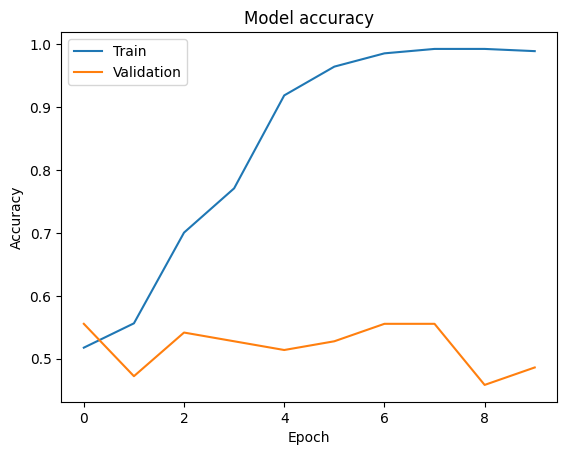

In [264]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

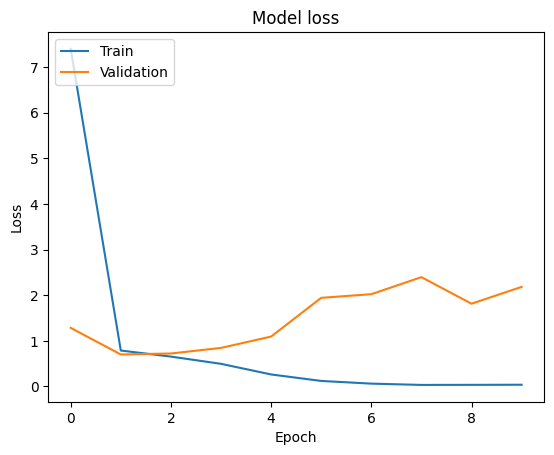

In [265]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [266]:
from sklearn.metrics import confusion_matrix, classification_report

In [267]:
y_pred = model.predict([test_sequences, test_images])
y_pred_classes = (y_pred > 0.5).astype(int)

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [268]:
test_labels_binary = (test_labels == 'offensive').astype(int)

In [269]:
cm = confusion_matrix(test_labels_binary, y_pred_classes)

In [270]:
cm

array([[39, 13],
       [21, 16]])

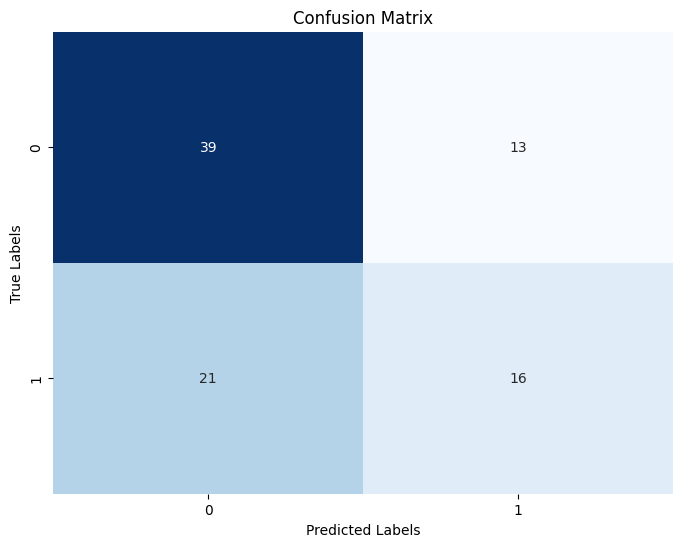

               precision    recall  f1-score   support

Non-offensive       0.65      0.75      0.70        52
    Offensive       0.55      0.43      0.48        37

     accuracy                           0.62        89
    macro avg       0.60      0.59      0.59        89
 weighted avg       0.61      0.62      0.61        89



In [271]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_names = ['Non-offensive', 'Offensive']
print(classification_report(test_labels_binary, y_pred_classes, target_names=class_names))

## BiLSTM

In [272]:
from tensorflow.keras.layers import Bidirectional, LSTM

In [273]:
text_input = Input(shape=(max_sequence_length,))
text_embedding = Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length)(text_input)
text_bilstm = Bidirectional(LSTM(128))(text_embedding)


In [274]:
image_input = Input(shape=(image_width, image_height, 3))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
flatten = Flatten()(maxpool2)

In [275]:
concatenated = concatenate([text_bilstm, flatten])

In [276]:
dense1 = Dense(128, activation='relu')(concatenated)
output = Dense(1, activation='sigmoid')(dense1)

In [277]:
model = Model(inputs=[text_input, image_input], outputs=output)

In [278]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 195)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 195, 100)  │    376,700 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    234,496 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 186624)    │          0 │ max_pooling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 186880)    │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │ 23,920,768 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,551,485 (93.66 MB)

 Trainable params: 24,551,485 (93.66 MB)

 Non-trainable params: 0 (0.00 B)

In [279]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [280]:
history = model.fit([train_sequences, train_images], train_labels_encoded, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5088 - loss: 7.7874 - val_accuracy: 0.4028 - val_loss: 0.9962
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5011 - loss: 0.7984 - val_accuracy: 0.4722 - val_loss: 0.7554
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6827 - loss: 0.5779 - val_accuracy: 0.4722 - val_loss: 0.8788
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8469 - loss: 0.4135 - val_accuracy: 0.4722 - val_loss: 0.9718
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9307 - loss: 0.2460 - val_accuracy: 0.4444 - val_loss: 1.1259
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9592 - loss: 0.1249 - val_accuracy: 0.5833 - val_loss: 1.6939
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9939 - loss: 0.0829 - val_accuracy: 0.5417 - val_loss: 1.3416
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9958 - loss: 0.0478 - val_accuracy: 0.5139 - val_loss: 1.3187
Epoch 9/

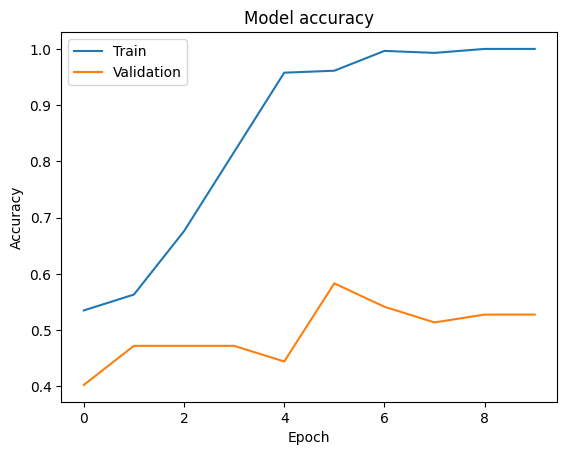

In [281]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

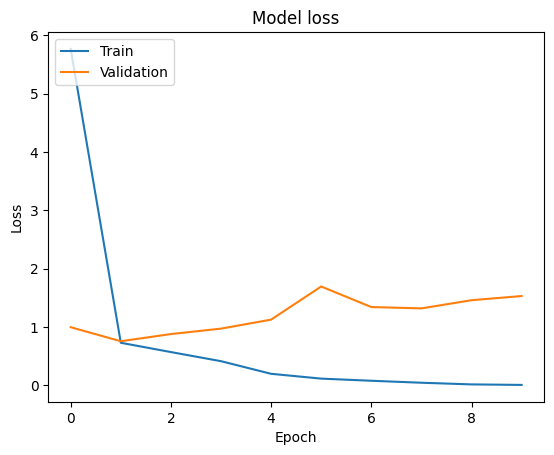

In [282]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [283]:
y_pred = model.predict([test_sequences, test_images])
y_pred_classes = (y_pred > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 857ms/step


In [284]:
test_labels_binary = (test_labels == 'offensive').astype(int)

In [285]:
cm = confusion_matrix(test_labels_binary, y_pred_classes)

In [286]:
cm


array([[38, 14],
       [20, 17]])

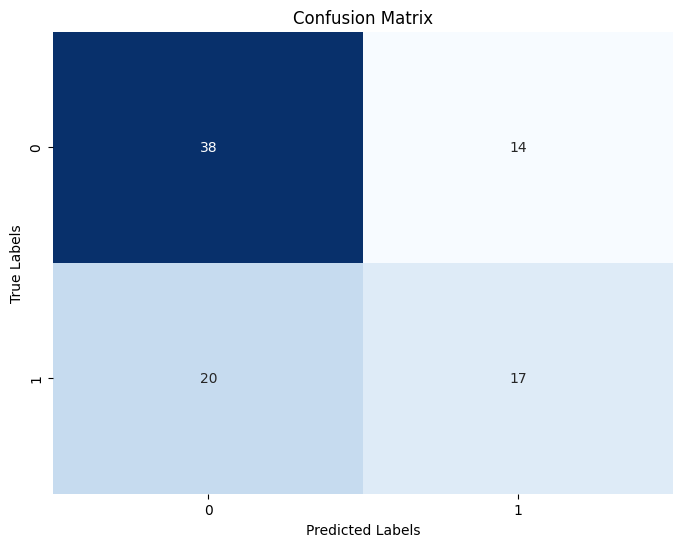

               precision    recall  f1-score   support

Non-offensive       0.66      0.73      0.69        52
    Offensive       0.55      0.46      0.50        37

     accuracy                           0.62        89
    macro avg       0.60      0.60      0.60        89
 weighted avg       0.61      0.62      0.61        89



In [287]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

class_names = ['Non-offensive', 'Offensive']
print(classification_report(test_labels_binary, y_pred_classes, target_names=class_names))